In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import numpy as np
import pandas as pd
import scipy.io
!conda install scikit-image -y #uncomment if skimage not installed
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
# For clearer plots in Jupyter notebooks on macs
%config InlineBackend.figure_format = 'retina'
# gc.collect()

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.9.0
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



# All requested packages already installed.



In [2]:
# define input path
input_path = './input'
subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join(input_path, 'Subject_10.mat')]

# data_indexes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]

# define image size
width = 284
height = 284
width_out = 196
height_out = 196

In [3]:
# Define a function to threshold the fluid image
def thresh(x:np.ndarray, thresh:float=0.3):
    if x <= thresh:
        return 0
    else:
        return 1

thresh = np.vectorize(thresh, otypes=[np.float64])

In [4]:
# Visualize an image from Subject_01.mat
def visualize_image(image_idx: int, resized: bool = False) -> None:
    mat = scipy.io.loadmat(subject_path[0])
    img_tensor_1 = mat['images']
    manual_fluid_tensor_1 = mat['manualFluid1']

    if resized:
        img_array = np.transpose(img_tensor_1, (2, 0 ,1)) / 255 #normalising
        img_array = resize(img_array, (img_array.shape[0], width, height))
        fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0 ,1))
        fluid_array = thresh(fluid_array)
        fluid_array  = resize(fluid_array, (fluid_array.shape[0], width_out, height_out))

    else:
        img_array = np.transpose(img_tensor_1, (2, 0, 1))
        fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))

    plt.subplot(1, 2, 1)
    plt.imshow(img_array[image_idx])
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(fluid_array[image_idx])
    plt.axis("off")

    plt.tight_layout()
    plt.show()

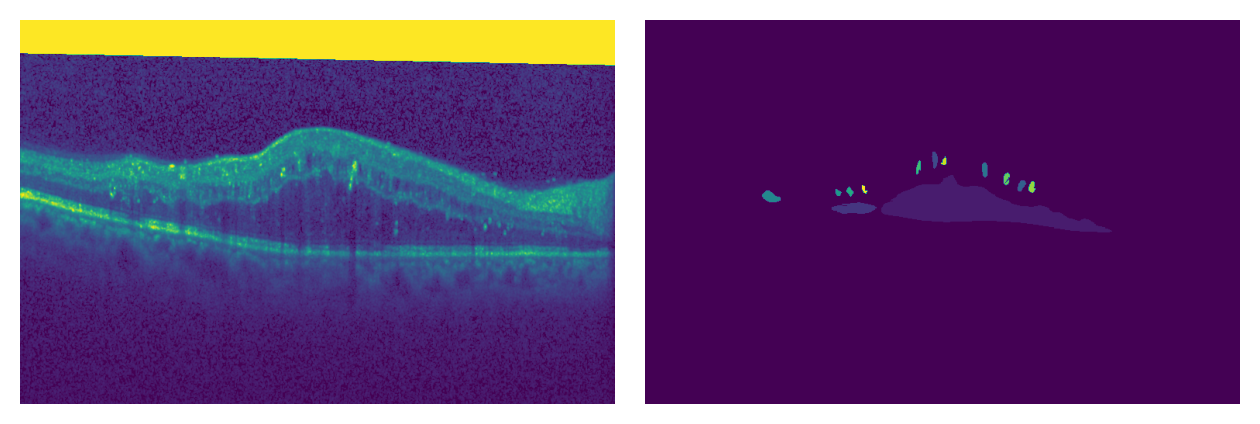

In [5]:
# Visualize an original image without resizing
visualize_image(25)

In [6]:
import matplotlib.image
import os
# Function to create a dataset from a list of file paths
def create_dataset(paths, data_group):
    x = []  # List to store input (image) data
    y = []  # List to store output (fluid mask) data
    
    # Iterate through each file path in the list
    for path in tqdm(paths):
        # Load MATLAB file using SciPy
        mat = scipy.io.loadmat(path)
        
        # Extract image tensor and fluid tensor from the loaded MATLAB file
        img_tensor = mat['images']
        fluid_tensor = mat['manualFluid1']
        
        # Transpose image tensor to have channel dimension as the first dimension, normalize, and resize
        img_array = np.transpose(img_tensor, (2, 0, 1)) / 255  # Normalizing pixel values
        img_array = resize(img_array, (img_array.shape[0], width, height))
        
        # Transpose fluid tensor, threshold, and resize
        fluid_array = np.transpose(fluid_tensor, (2, 0, 1))
        fluid_array = thresh(fluid_array)  # Assuming `thresh` is a function that thresholds the fluid mask
        fluid_array = resize(fluid_array, (fluid_array.shape[0], width_out, height_out))
        
        # Iterate through specified data indexes
        for idx in data_indexes:
            # Append the current image slice to x (input) and fluid mask slice to y (output)
            x += [np.expand_dims(img_array[idx], 0)]  # Add a singleton dimension
            y += [np.expand_dims(fluid_array[idx], 0)]  # Add a singleton dimension

            # save array as png
            matplotlib.image.imsave(f'img_{idx}_{data_group}.png', img_array[idx])
            matplotlib.image.imsave(f'fluid_{idx}_{data_group}.png', fluid_array[idx])
    
    # Convert lists to NumPy arrays and return
    return np.array(x), np.array(y)

# Creating training and validation datasets
x_train, y_train = create_dataset(subject_path[:9], 'train')
x_val, y_val = create_dataset(subject_path[9:], 'val')

  0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/envs/openmmlab/lib/python3.8/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in thresh (vectorized)
  outputs = ufunc(*inputs)
100%|██████████| 1/1 [00:07<00:00,  7.87s/it]


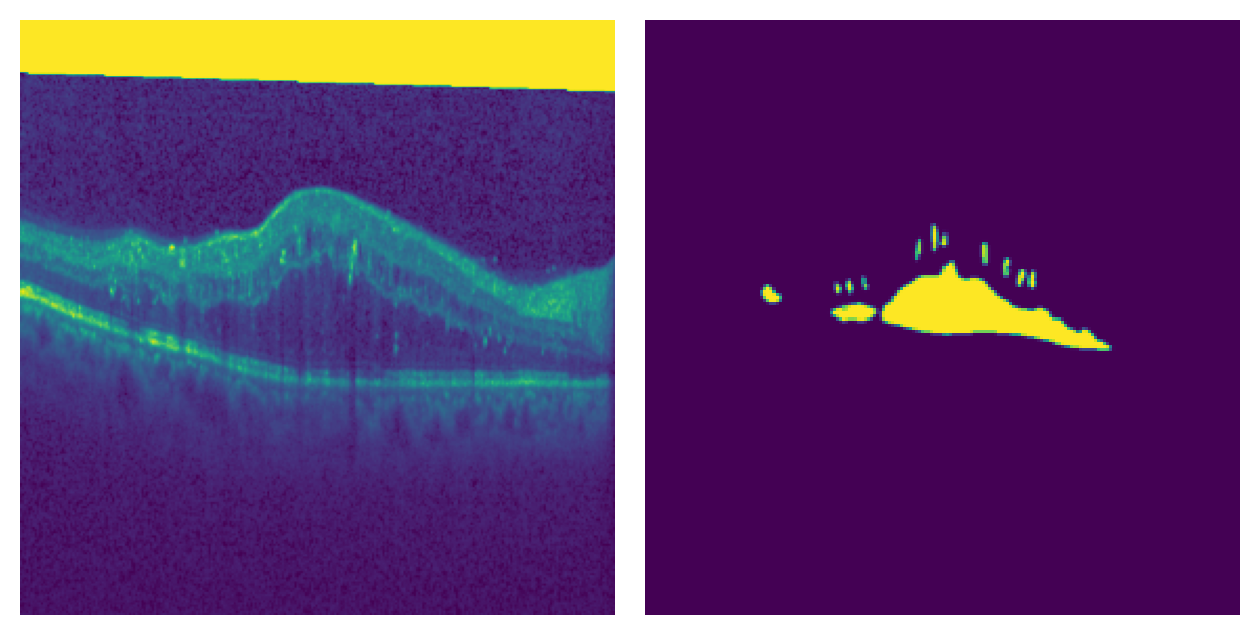

In [7]:
# visualize the resized image
visualize_image(25, resized=True)

In [8]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((99, 1, 284, 284), (99, 1, 196, 196), (11, 1, 284, 284), (11, 1, 196, 196))